In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetV2B0 # Switched to EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd # Added for history concatenation
import shutil # Added for directory cleanup

# --- GLOBAL VARIABLES & CLASS LABELS ---

CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10


# --- 1. Google Colab Setup (Mount Drive for Persistence and Backup) ---

# Logic for mounting Google Drive
try:
    from google.colab import drive
    print("--- Attempting to Mount Google Drive ---")
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ImportError:
    print("Not running in Colab environment. Skipping Google Drive mount.")

# Define paths for saving artifacts
# *** NEW PATHS FOR EFFICIENTNETV2B0 ISOLATION ***
BACKUP_DIR = "/content/drive/MyDrive/efficientnet_v2b0_backup_v_safe"
MODEL_SAVE_DIR = '/content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/'
MODEL_NAME = 'efficientnetv2b0_cifar10_best_v_safe.h5'
CHECKPOINT_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_NAME)

# --- CRITICAL CLEANUP: Ensure a genuinely FRESH start ---
if os.path.exists(BACKUP_DIR):
    print(f"ATTENTION: Clearing old backup directory: {BACKUP_DIR}")
    shutil.rmtree(BACKUP_DIR)
if os.path.exists(MODEL_SAVE_DIR):
    print(f"ATTENTION: Clearing old checkpoint directory: {MODEL_SAVE_DIR}")
    shutil.rmtree(MODEL_SAVE_DIR)
# --- END CLEANUP ---

# Ensure backup and checkpoint directories exist
os.makedirs(BACKUP_DIR, exist_ok=True)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"\nBackup Directory: {BACKUP_DIR}")
print(f"Best Model Checkpoint Path: {CHECKPOINT_PATH}")

--- Attempting to Mount Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.

Backup Directory: /content/drive/MyDrive/efficientnet_v2b0_backup_v_safe
Best Model Checkpoint Path: /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


In [18]:
# --- 2. Data Loading and Preprocessing ---

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"\nOriginal Input Shape: {x_train.shape}")

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, NUM_CLASSES)
y_test_one_hot = to_categorical(y_test, NUM_CLASSES)

# CRITICAL FIX: Cast to float32 but KEEP IN [0, 255] RANGE.
# EfficientNetV2 handles the 0-255 scaling internally via its Rescaling layer.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Store integer labels for evaluation metrics later
y_test_int = y_test



Original Input Shape: (50000, 32, 32, 3)


In [19]:
# Data Augmentation Setup
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

In [20]:
# --- 3. Model Definition and Upscaling ---

INPUT_SHAPE = (32, 32, 3)
TARGET_SHAPE = (160, 160, 3)
SCALE_FACTOR = 5 # 32 * 5 = 160 (Upscaling to match typical EfficientNet input)

# 1. Input layer (takes the original 32x32 CIFAR image)
img_input = Input(shape=INPUT_SHAPE)

# 2. Upscaling layer
x = UpSampling2D(size=(SCALE_FACTOR, SCALE_FACTOR), interpolation='bilinear', name='upscale_layer')(img_input)

# 3. EfficientNet-specific preprocessing
# The preprocessing is now handled internally by EfficientNetV2B0 itself

# 4. Base Model (EfficientNetV2B0 pre-trained on ImageNet)
base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet', # RELOADING CLEAN IMAGENET WEIGHTS
    input_tensor=x,
    input_shape=TARGET_SHAPE,
    pooling=None
)

# 5. New Classification Head for CIFAR-10
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = Model(inputs=img_input, outputs=x, name="efficientnet_cifar10_finetune")


# --- 4. Callbacks and Training Preparation (Setup) ---

callbacks = [
    # 1. BACKUP AND RESTORE (Training Resilience)
    tf.keras.callbacks.BackupAndRestore(
        backup_dir=BACKUP_DIR
    ),

    # 2. MODEL CHECKPOINT (Best Weights Backup)
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # 3. EARLY STOPPING
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1
    )
]

In [21]:
# Initialize history lists
history_combined = None


# --- PHASE 2: SELECTIVE FINE-TUNING (The safe approach) ---
# NOTE: This is the critical phase where we adapt the ImageNet features.

print("\n" + "="*50)
print("PHASE 2: SELECTIVE FINE-TUNING (Adaptation)")
print("="*50)

# CRITICAL STEP 1: Globally unfreeze the base model
base_model.trainable = True

# Define a more conservative freeze count for the smaller B0 model
FREEZE_FIRST_N_LAYERS = 70
num_layers = len(base_model.layers)

print(f"Total layers in EfficientNetV2B0 base: {num_layers}")
print(f"Freezing the first {FREEZE_FIRST_N_LAYERS} layers and unfreezing the rest for fine-tuning...")

# Loop through the base model and set trainability
for i, layer in enumerate(base_model.layers):
    if i < FREEZE_FIRST_N_LAYERS:
        # Freeze the first N layers (generic features)
        layer.trainable = False
    else:
        # Unfreeze the remaining, deeper layers (task-specific features)
        layer.trainable = True

# Re-compile the model with the necessary LOW learning rate
optimizer_safe = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer_safe,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# --- EPOCH CONTROL (Phase 2) ---

INITIAL_PHASE2_EPOCHS_COMPLETED = 0
TOTAL_PHASE2_EPOCHS_TO_RUN = 30 # Run for 30 epochs in total

print(f"Starting Phase 2 training. Total epochs to run: {TOTAL_PHASE2_EPOCHS_TO_RUN} (Starting from {INITIAL_PHASE2_EPOCHS_COMPLETED})")

# Train Phase 2
history_combined = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=32),
    epochs=TOTAL_PHASE2_EPOCHS_TO_RUN,
    initial_epoch=INITIAL_PHASE2_EPOCHS_COMPLETED, # Explicitly set start epoch
    validation_data=(x_test, y_test_one_hot),
    callbacks=callbacks,
    verbose=1
)



PHASE 2: SELECTIVE FINE-TUNING (Adaptation)
Total layers in EfficientNetV2B0 base: 271
Freezing the first 70 layers and unfreezing the rest for fine-tuning...
Starting Phase 2 training. Total epochs to run: 30 (Starting from 0)
Epoch 1/30
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4682 - loss: 1.6667
Epoch 1: val_accuracy improved from -inf to 0.89800, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 137s 49ms/step - accuracy: 0.4686 - loss: 1.6657 - val_accuracy: 0.8980 - val_loss: 0.3856
Epoch 2/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8549 - loss: 0.4488
Epoch 2: val_accuracy improved from 0.89800 to 0.93000, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8549 - loss: 0.4487 - val_accuracy: 0.9300 - val_loss: 0.2410
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8884 - loss: 0.3381
Epoch 3: val_accuracy improved from 0.93000 to 0.93790, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8884 - loss: 0.3381 - val_accuracy: 0.9379 - val_loss: 0.1990
Epoch 4/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9027 - loss: 0.2885
Epoch 4: val_accuracy improved from 0.93790 to 0.94320, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9027 - loss: 0.2885 - val_accuracy: 0.9432 - val_loss: 0.1755
Epoch 5/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9160 - loss: 0.2509
Epoch 5: val_accuracy improved from 0.94320 to 0.95060, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.9160 - loss: 0.2509 - val_accuracy: 0.9506 - val_loss: 0.1526
Epoch 6/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9242 - loss: 0.2251
Epoch 6: val_accuracy improved from 0.95060 to 0.95130, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.9242 - loss: 0.2251 - val_accuracy: 0.9513 - val_loss: 0.1470
Epoch 7/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9296 - loss: 0.2103
Epoch 7: val_accuracy improved from 0.95130 to 0.95530, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9296 - loss: 0.2103 - val_accuracy: 0.9553 - val_loss: 0.1326
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9349 - loss: 0.1918
Epoch 8: val_accuracy did not improve from 0.95530
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.9349 - loss: 0.1918 - val_accuracy: 0.9545 - val_loss: 0.1302
Epoch 9/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9386 - loss: 0.1791
Epoch 9: val_accuracy improved from 0.95530 to 0.95730, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9386 - loss: 0.1791 - val_accuracy: 0.9573 - val_loss: 0.1219
Epoch 10/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9437 - loss: 0.1645
Epoch 10: val_accuracy improved from 0.95730 to 0.95900, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9437 - loss: 0.1645 - val_accuracy: 0.9590 - val_loss: 0.1204
Epoch 11/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9480 - loss: 0.1506
Epoch 11: val_accuracy improved from 0.95900 to 0.96190, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9480 - loss: 0.1506 - val_accuracy: 0.9619 - val_loss: 0.1132
Epoch 12/30
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9516 - loss: 0.1426
Epoch 12: val_accuracy improved from 0.96190 to 0.96230, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9516 - loss: 0.1426 - val_accuracy: 0.9623 - val_loss: 0.1114
Epoch 13/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9526 - loss: 0.1412
Epoch 13: val_accuracy improved from 0.96230 to 0.96380, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9526 - loss: 0.1412 - val_accuracy: 0.9638 - val_loss: 0.1083
Epoch 14/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9550 - loss: 0.1315
Epoch 14: val_accuracy did not improve from 0.96380
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.9550 - loss: 0.1315 - val_accuracy: 0.9634 - val_loss: 0.1096
Epoch 15/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9588 - loss: 0.1216
Epoch 15: val_accuracy improved from 0.96380 to 0.96510, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9588 - loss: 0.1216 - val_accuracy: 0.9651 - val_loss: 0.1035
Epoch 16/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9614 - loss: 0.1127
Epoch 16: val_accuracy did not improve from 0.96510
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.9614 - loss: 0.1127 - val_accuracy: 0.9639 - val_loss: 0.1031
Epoch 17/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9641 - loss: 0.1049
Epoch 17: val_accuracy did not improve from 0.96510
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.9641 - loss: 0.1049 - val_accuracy: 0.9639 - val_loss: 0.1075
Epoch 18/30
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9648 - loss: 0.1032
Epoch 18: val_accuracy did not improve from 0.96510
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.9648 - loss: 0.1032 - val_accuracy: 0.9635 - val_loss: 0.1057
Epoch 19/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9690 - loss: 0.0911


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.9693 - loss: 0.0890 - val_accuracy: 0.9662 - val_loss: 0.1016
Epoch 21/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9701 - loss: 0.0847
Epoch 21: val_accuracy did not improve from 0.96620
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9701 - loss: 0.0847 - val_accuracy: 0.9661 - val_loss: 0.1028
Epoch 22/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9718 - loss: 0.0832
Epoch 22: val_accuracy improved from 0.96620 to 0.96750, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.9718 - loss: 0.0832 - val_accuracy: 0.9675 - val_loss: 0.0987
Epoch 23/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9736 - loss: 0.0764
Epoch 23: val_accuracy did not improve from 0.96750
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9736 - loss: 0.0764 - val_accuracy: 0.9665 - val_loss: 0.1008
Epoch 24/30
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9750 - loss: 0.0747
Epoch 24: val_accuracy improved from 0.96750 to 0.96780, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.9750 - loss: 0.0747 - val_accuracy: 0.9678 - val_loss: 0.0984
Epoch 25/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9747 - loss: 0.0697
Epoch 25: val_accuracy did not improve from 0.96780
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.9747 - loss: 0.0697 - val_accuracy: 0.9665 - val_loss: 0.1035
Epoch 26/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9769 - loss: 0.0684
Epoch 26: val_accuracy improved from 0.96780 to 0.96940, saving model to /content/drive/MyDrive/EfficientNetV2B0_Checkpoints_v_safe/efficientnetv2b0_cifar10_best_v_safe.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.9769 - loss: 0.0684 - val_accuracy: 0.9694 - val_loss: 0.0968
Epoch 27/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9792 - loss: 0.0624
Epoch 27: val_accuracy did not improve from 0.96940
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9792 - loss: 0.0624 - val_accuracy: 0.9684 - val_loss: 0.1016
Epoch 28/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9784 - loss: 0.0615
Epoch 28: val_accuracy did not improve from 0.96940
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9784 - loss: 0.0615 - val_accuracy: 0.9664 - val_loss: 0.1058
Epoch 29/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9793 - loss: 0.0604
Epoch 29: val_accuracy did not improve from 0.96940
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9793 - loss: 0.0604 - val_accuracy: 0.9679 - val_loss: 0.1006
Epoch 30/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9806 - loss: 0.0572


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.9806 - loss: 0.0572 - val_accuracy: 0.9695 - val_loss: 0.0976


In [22]:
# Initialize history lists
history_combined = None


# --- PHASE 2: SELECTIVE FINE-TUNING (The safe approach) ---
# NOTE: This is the critical phase where we adapt the ImageNet features.

print("\n" + "="*50)
print("PHASE 2: SELECTIVE FINE-TUNING (Adaptation)")
print("="*50)

# CRITICAL STEP 1: Globally unfreeze the base model
base_model.trainable = True

# Define a more conservative freeze count for the smaller B0 model
FREEZE_FIRST_N_LAYERS = 70
num_layers = len(base_model.layers)

print(f"Total layers in EfficientNetV2B0 base: {num_layers}")
print(f"Freezing the first {FREEZE_FIRST_N_LAYERS} layers and unfreezing the rest for fine-tuning...")

# Loop through the base model and set trainability
for i, layer in enumerate(base_model.layers):
    if i < FREEZE_FIRST_N_LAYERS:
        # Freeze the first N layers (generic features)
        layer.trainable = False
    else:
        # Unfreeze the remaining, deeper layers (task-specific features)
        layer.trainable = True

# Re-compile the model with the necessary LOW learning rate
optimizer_safe = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer_safe,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# --- EPOCH CONTROL (Phase 2) ---

INITIAL_PHASE2_EPOCHS_COMPLETED = 30
TOTAL_PHASE2_EPOCHS_TO_RUN = 50 # Run for 30 epochs in total

print(f"Starting Phase 2 training. Total epochs to run: {TOTAL_PHASE2_EPOCHS_TO_RUN} (Starting from {INITIAL_PHASE2_EPOCHS_COMPLETED})")

# Train Phase 2
history_combined = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=32),
    epochs=TOTAL_PHASE2_EPOCHS_TO_RUN,
    initial_epoch=INITIAL_PHASE2_EPOCHS_COMPLETED, # Explicitly set start epoch
    validation_data=(x_test, y_test_one_hot),
    callbacks=callbacks,
    verbose=1
)



PHASE 2: SELECTIVE FINE-TUNING (Adaptation)
Total layers in EfficientNetV2B0 base: 271
Freezing the first 70 layers and unfreezing the rest for fine-tuning...
Starting Phase 2 training. Total epochs to run: 50 (Starting from 30)
Epoch 31/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9832 - loss: 0.0526
Epoch 31: val_accuracy did not improve from 0.96950
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 54ms/step - accuracy: 0.9832 - loss: 0.0526 - val_accuracy: 0.9674 - val_loss: 0.1038
Epoch 32/50
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9825 - loss: 0.0500
Epoch 32: val_accuracy did not improve from 0.96950
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.9825 - loss: 0.0500 - val_accuracy: 0.9695 - val_loss: 0.0994
Epoch 33/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9835 - loss: 0.0481
Epoch 33: val_accuracy did not improve from 0.96950
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9835 - loss: 0.0481 - val_accuracy: 0.9662


FINAL EVALUATION (Loading Best Model)

Test Accuracy (Best Checkpoint): 96.95%

--- Generating Detailed Classification Metrics ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane       0.98      0.97      0.98      1000
  automobile       0.98      0.97      0.98      1000
        bird       0.97      0.97      0.97      1000
         cat       0.94      0.92      0.93      1000
        deer       0.97      0.97      0.97      1000
         dog       0.93      0.95      0.94      1000
        frog       0.98      0.99      0.98      1000
       horse       0.98      0.98      0.98      1000
        ship       0.99      0.99      0.99      1000
       truck       0.97      0.98      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



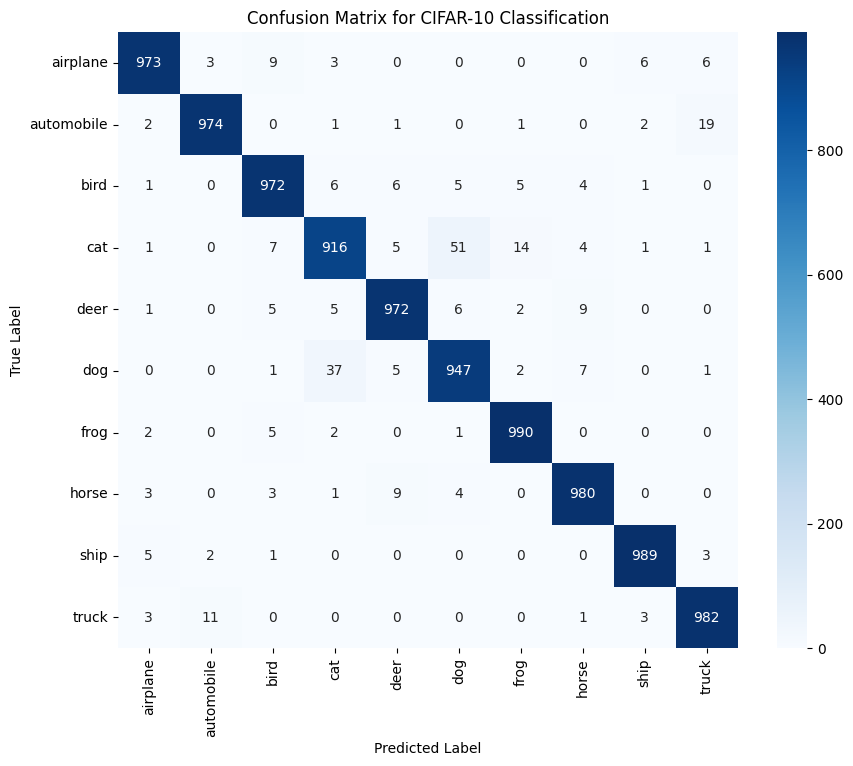

In [25]:
print("\n" + "="*50)
print("FINAL EVALUATION (Loading Best Model)")
print("="*50)

try:
    model.load_weights(CHECKPOINT_PATH)
    loss, accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)
    print(f"\nTest Accuracy (Best Checkpoint): {accuracy*100:.2f}%")

    print("\n--- Generating Detailed Classification Metrics ---")

    # 1. Get predictions (probabilities)
    y_pred_probs = model.predict(x_test)

    # 2. Convert probabilities to class indices
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # 3. Get true class indices
    y_true_classes = y_test_int.flatten()

    # A. Classification report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true_classes, y_pred_classes, target_names=CIFAR10_LABELS))

    # B. Confusion matrix visualization
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=CIFAR10_LABELS,
        yticklabels=CIFAR10_LABELS
    )
    plt.title('Confusion Matrix for CIFAR-10 Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

except Exception as e:
    print(f"Error loading weights or evaluating model: {e}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


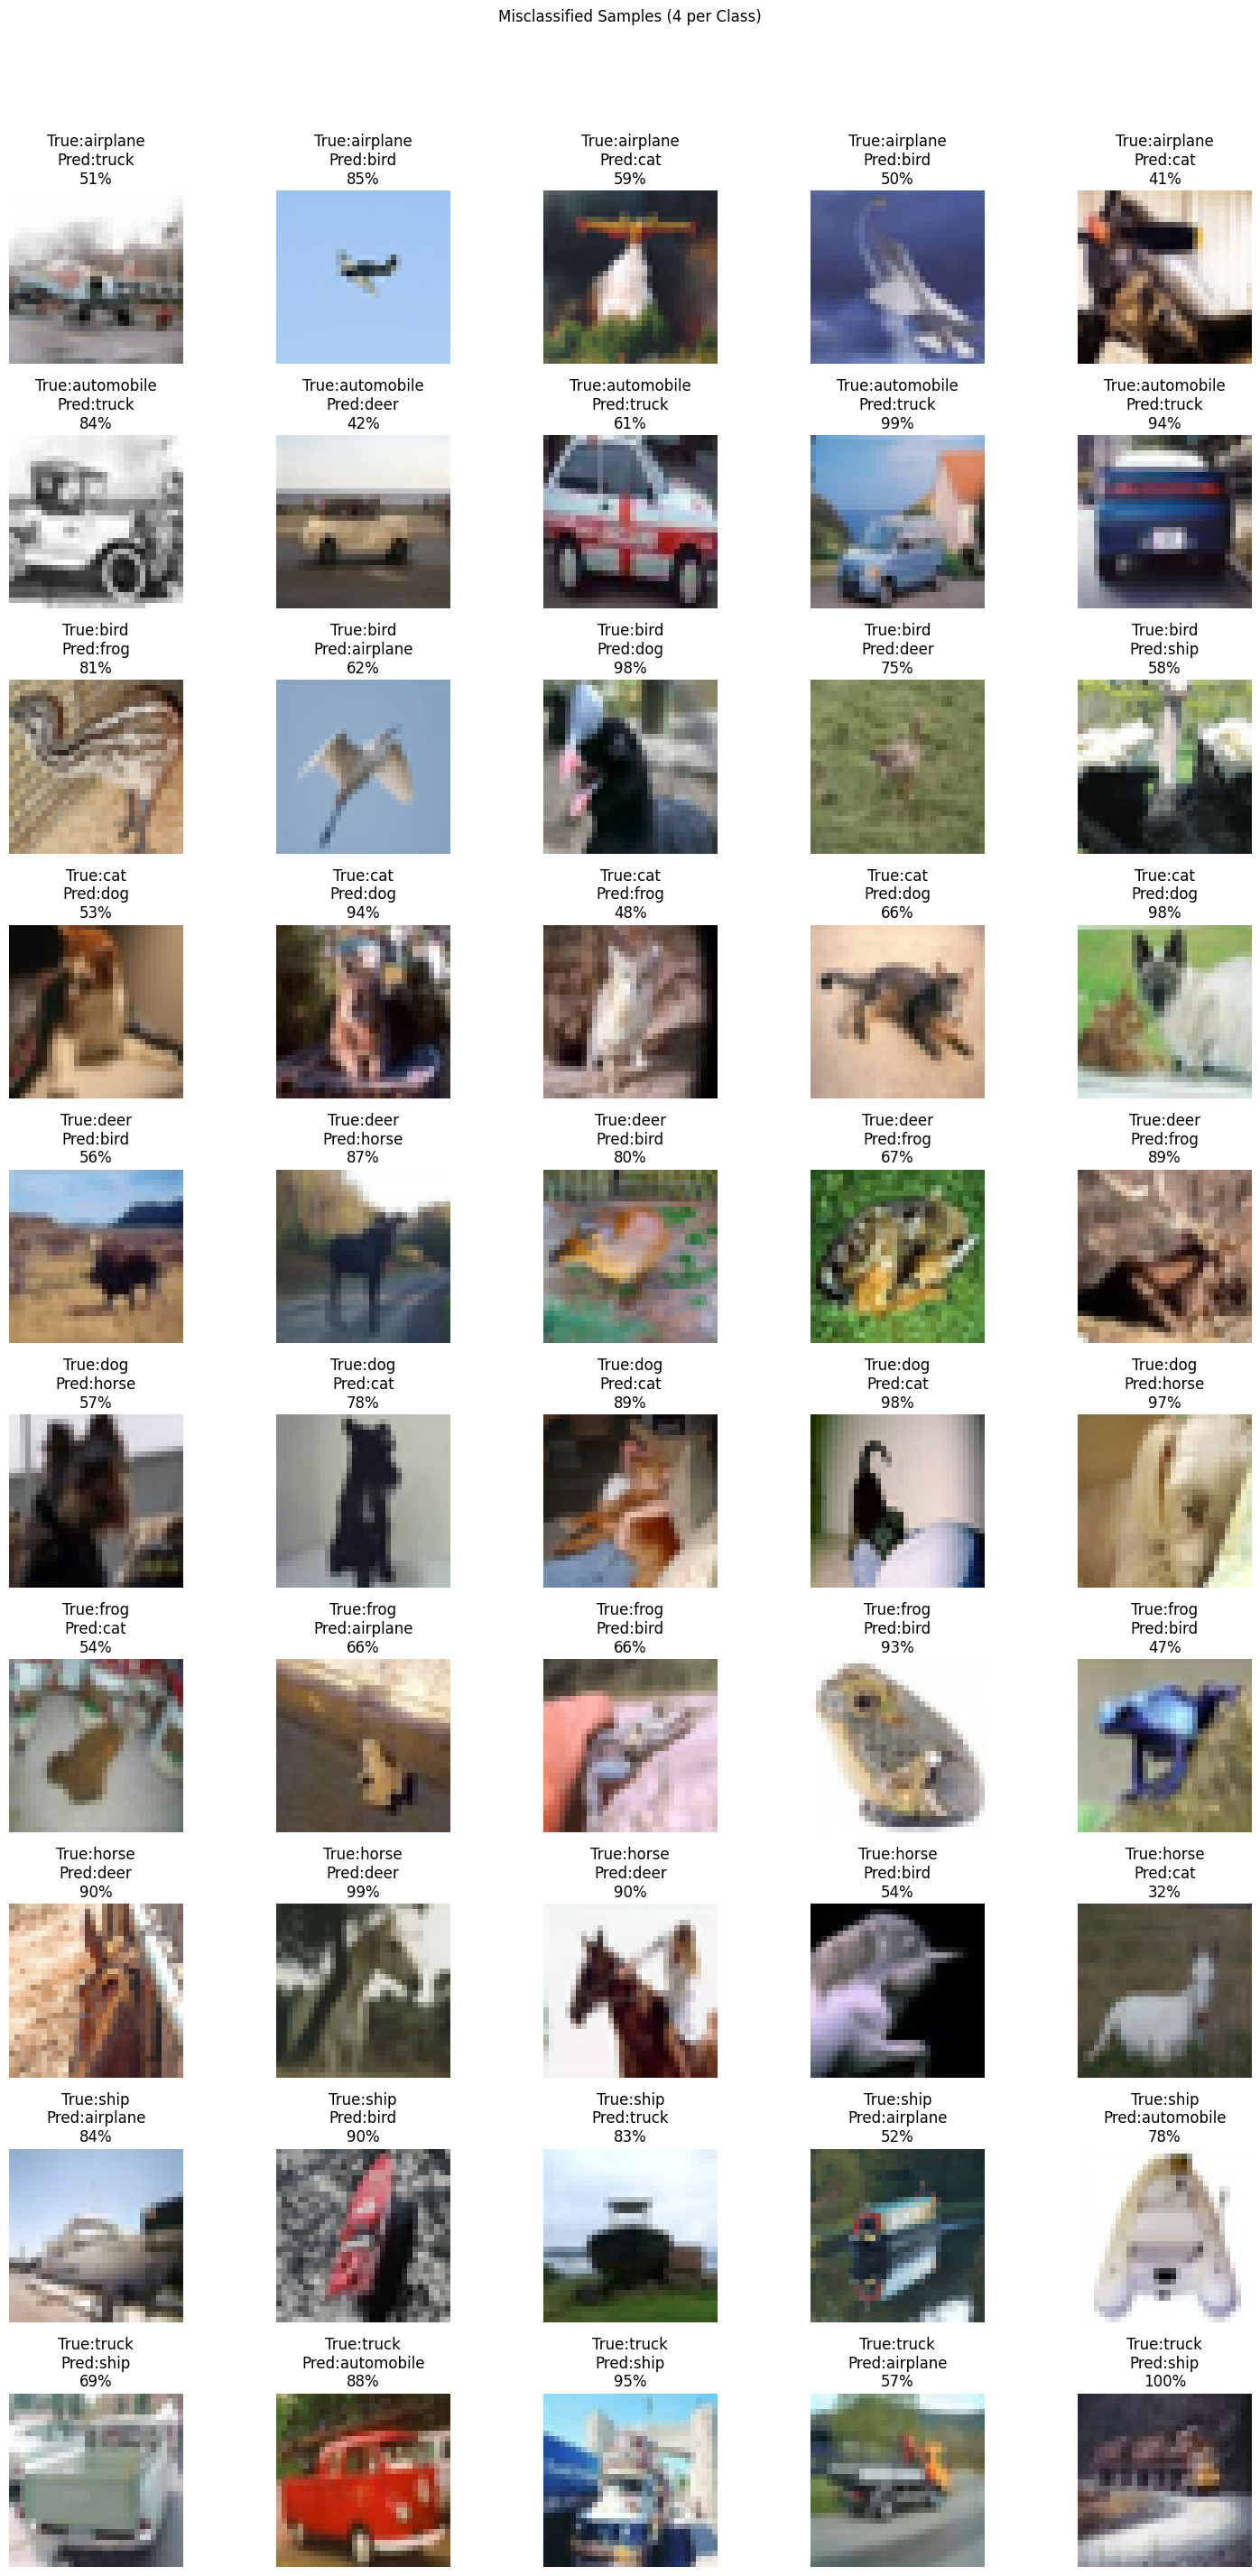

In [34]:
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(CIFAR10_LABELS)
samples_per_class = 5

# Predict all test samples
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Ensure y_true_classes is defined as true class indices
# (If your test labels are one-hot encoded, use np.argmax)
if len(y_test_one_hot.shape) > 1:
    y_true_classes = np.argmax(y_test_one_hot, axis=1)
else:
    y_true_classes = y_test_int.flatten()

fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class*3, num_classes*3))
fig.suptitle("Misclassified Samples (4 per Class)")

for class_idx in range(num_classes):
    # Indices of all samples in this class
    class_indices = np.where(y_true_classes == class_idx)[0]
    # Misclassifications for this class
    misclassified_indices = [i for i in class_indices if y_pred_classes[i] != class_idx]

    # Pick up to 4 misclassified indices
    for j in range(samples_per_class):
        ax = axes[class_idx, j]
        if j < len(misclassified_indices):
            idx = misclassified_indices[j]
            true_label = CIFAR10_LABELS[class_idx]
            predicted_label = CIFAR10_LABELS[y_pred_classes[idx]]
            confidence = y_pred_probs[idx][y_pred_classes[idx]] * 100

            # Safely rescale image for correct visualization
            img_to_display = x_test[idx]
            if img_to_display.dtype == np.float32 or img_to_display.dtype == np.float64:
                # Rescale only if needed
                if img_to_display.max() > 1.0:
                    img_to_display = img_to_display / 255.0

            ax.imshow(img_to_display)
            ax.set_title(f"True:{true_label}\nPred:{predicted_label}\n{confidence:.0f}%")
        else:
            ax.axis('off')  # Hide axes if fewer than 4 misclassifications
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


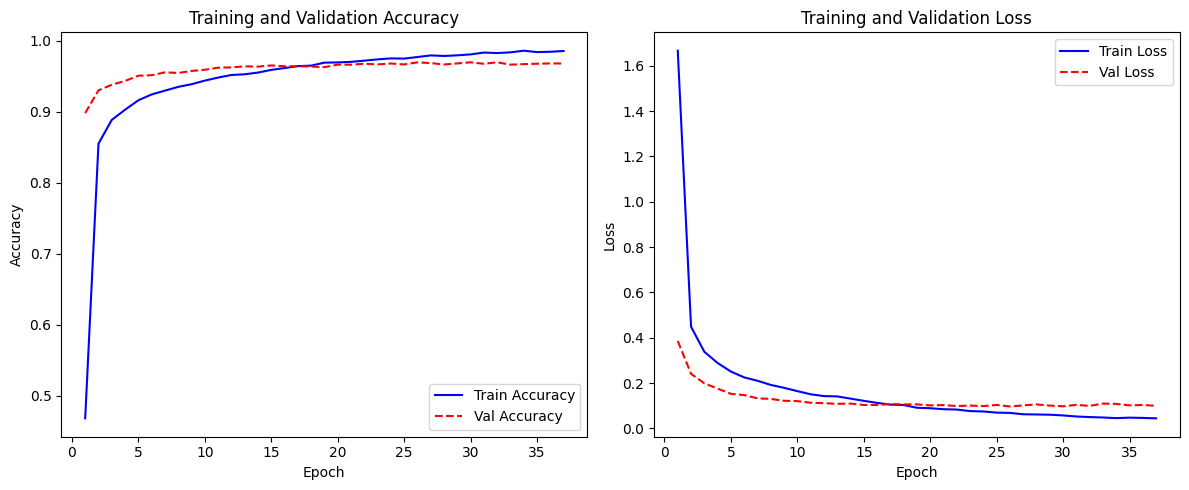

In [33]:
import matplotlib.pyplot as plt

train_acc = [
    0.4682, 0.8549, 0.8884, 0.9027, 0.9160, 0.9242, 0.9296, 0.9349, 0.9386, 0.9437, 0.9480,
    0.9516, 0.9526, 0.9550, 0.9588, 0.9614, 0.9641, 0.9648, 0.9690, 0.9693, 0.9701,
    0.9718, 0.9736, 0.9750, 0.9747, 0.9769, 0.9792, 0.9784, 0.9793, 0.9806,
    0.9832, 0.9825, 0.9835, 0.9858, 0.9839, 0.9843, 0.9854
]
val_acc = [
    0.8980, 0.9300, 0.9379, 0.9432, 0.9506, 0.9513, 0.9553, 0.9545, 0.9573, 0.9590, 0.9619,
    0.9623, 0.9638, 0.9634, 0.9651, 0.9639, 0.9639, 0.9635, 0.9626, 0.9662, 0.9661,
    0.9675, 0.9665, 0.9678, 0.9665, 0.9694, 0.9684, 0.9664, 0.9679, 0.9695,
    0.9674, 0.9695, 0.9662, 0.9669, 0.9675, 0.9679, 0.9678
]
train_loss = [
    1.6667, 0.4488, 0.3381, 0.2885, 0.2509, 0.2251, 0.2103, 0.1918, 0.1791, 0.1645, 0.1506,
    0.1426, 0.1412, 0.1315, 0.1216, 0.1127, 0.1049, 0.1032, 0.0911, 0.0890, 0.0847,
    0.0832, 0.0764, 0.0747, 0.0697, 0.0684, 0.0624, 0.0615, 0.0604, 0.0572,
    0.0526, 0.0500, 0.0481, 0.0453, 0.0475, 0.0462, 0.0444
]
val_loss = [
    0.3856, 0.2410, 0.1990, 0.1755, 0.1526, 0.1470, 0.1326, 0.1302, 0.1219, 0.1204, 0.1132,
    0.1114, 0.1083, 0.1096, 0.1035, 0.1031, 0.1075, 0.1057, 0.1061, 0.1016, 0.1028,
    0.0987, 0.1008, 0.0984, 0.1035, 0.0968, 0.1016, 0.1058, 0.1006, 0.0976,
    0.1038, 0.0994, 0.1095, 0.1082, 0.1016, 0.1035, 0.0994
]

epochs = range(1, 38) # 1 to 37

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()
